# Example 1 - Beginner Friendly
In this Data Analysis will be to practice with `Python and libraries`

[Digimon DB KAGGLE](https://www.kaggle.com/datasets/rtatman/digidb)

This dataset contains information on digimon from “Digimon Digimon Story: Cyber Sleuth”, released for Playstation Vita in 2015 and Playstation 4 in 2016.

**Content:**

This database contains three files: a list of all the digimon that can be captured or fought in Cyber Sleuth, all the moves which Digimon can perform, and all the Support Skills. (Support Skills are a passive, stackable, team-wide buff. Each species of Digimon is associated with a single Support Skill.)

* Which set of moves will get the best ratio of attack power to SP spent?
* Which team of 3 digimon have the highest attack? Defense?
* What’s the tradeoff between HP and SP?
* Are some types over- or under-represented?
* Both the moves and support skills have short text descriptions. Can an NLP analysis reveal underlying clusters of moves?
* Are different types and attributes evenly represented across stages?

## 1. Dependency and Format

Python 3.10.11


In [1]:
# Classic Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import clean_columns

# Advanced Visualization Libraries
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud

In [9]:
# Display float with 2 decimal values
pd.options.display.float_format = "{:.2f}".format

In [13]:
import inspect
inspect.getmembers(pd.options.display)

[('chop_threshold', None),
 ('colheader_justify', 'right'),
 ('column_space', 12),
 ('date_dayfirst', False),
 ('date_yearfirst', False),
 ('encoding', 'UTF-8'),
 ('expand_frame_repr', True),
 ('float_format', None),
 ('html', <pandas._config.config.DictWrapper at 0x19f45224dc0>),
 ('large_repr', 'truncate'),
 ('latex', <pandas._config.config.DictWrapper at 0x19f452251b0>),
 ('max_categories', 8),
 ('max_columns', 20),
 ('max_colwidth', 50),
 ('max_dir_items', 100),
 ('max_info_columns', 100),
 ('max_info_rows', 1690785),
 ('max_rows', 60),
 ('max_seq_items', 100),
 ('memory_usage', True),
 ('min_rows', 10),
 ('multi_sparse', True),
 ('notebook_repr_html', True),
 ('pprint_nest_depth', 3),
 ('precision', 6),
 ('show_dimensions', 'truncate'),
 ('unicode', <pandas._config.config.DictWrapper at 0x19f452257e0>),
 ('width', 80)]

In [23]:
inspect.getmembers(pd, predicate=inspect.ismethod)

c:\Users\herre\anaconda3\envs\data-env\lib\inspect.py:469: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
c:\Users\herre\anaconda3\envs\data-env\lib\inspect.py:469: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
c:\Users\herre\anaconda3\envs\data-env\lib\inspect.py:469: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)


[]

In [8]:
dir(pd.options.display)

['chop_threshold',
 'colheader_justify',
 'column_space',
 'date_dayfirst',
 'date_yearfirst',
 'encoding',
 'expand_frame_repr',
 'float_format',
 'html',
 'large_repr',
 'latex',
 'max_categories',
 'max_columns',
 'max_colwidth',
 'max_dir_items',
 'max_info_columns',
 'max_info_rows',
 'max_rows',
 'max_seq_items',
 'memory_usage',
 'min_rows',
 'multi_sparse',
 'notebook_repr_html',
 'pprint_nest_depth',
 'precision',
 'show_dimensions',
 'unicode',
 'width']

#### Helpers

In [10]:
# Checking if I can change the types to more efficient memory usage
import numpy as np

np.iinfo(np.int16)

iinfo(min=-32768, max=32767, dtype=int16)

In [11]:
from IPython.display import display


def create_var(df, var_name):
    """This function is to create a variable with the main DataFrame without change the main one
    Use it when you have to debug or modify anything"""
    globals()[var_name] = df
    return df

## 2. Get and Inspect Data

In [12]:
db = pd.read_csv("data/db_digimonlist.csv")
db_move = pd.read_csv("data/db_movelist.csv")
db_support = pd.read_csv("data/db_supportlist.csv")

In [13]:
# Sample data
db.sample(5)

,Number,Digimon,Stage,Type,Attribute,Memory,Equip Slots,Lv 50 HP,Lv50 SP,Lv50 Atk,Lv50 Def,Lv50 Int,Lv50 Spd
192,193,TigerVespamon,Mega,Virus,Electric,18,3,1630,104,193,114,99,173
244,245,Valkyrimon,Mega,Free,Wind,18,3,1330,139,148,129,129,168
219,220,MirageGaogamon,Mega,Data,Wind,18,3,1480,114,183,114,109,178
114,115,AeroVeedramon,Ultimate,Vaccine,Wind,14,1,1430,94,163,99,94,153
138,139,Panjyamon,Ultimate,Vaccine,Water,12,2,1280,128,124,114,111,126


In [85]:
# Capture the variables to impute in a list.
def grab_cols(df):

    vars_to_impute = [var for var in df.columns if df[var].isnull().sum() > 0]

    # Capture numerical variables
    vars_num = list(df.select_dtypes(include="number").columns)

    # Capture categorical variables
    vars_cat = list(df.select_dtypes(exclude="number").columns)

    # Create the imputation dictionary
    # median imputation for numeric
    imputation_dict = df[vars_num].median().to_dict()

    # add mode imputation for categoric
    imputation_dict.update(df[vars_cat].mode().iloc[0].to_dict())

    # show final dictionary
    indicators = [f"{var}_na" for var in df[vars_to_impute].columns]
    # Add missing indicators 
    df_indicators = df.copy()
    df_indicators[indicators] = df_indicators[vars_to_impute].isna().astype(int)
    # After adding indicators, we can replace missing data
    # in the original variables

    df_indicators = df_indicators.fillna(imputation_dict)
    print(" RESULT ".center(50, "-"))
    print(f"Imputations:\n {imputation_dict}")
    print("".center(50, "-"))
    print("New DataFrame:\n")
    display(df_indicators)

    return df_indicators,imputation_dict
# end def



In [86]:
grab_cols(db)
grab_cols(db_move)
grab_cols(db_support)

--------------------- RESULT ---------------------
Imputations:
 {'Memory': 12.0, 'Equip Slots': 1.0, 'Lv 50 HP': 1180.0, 'Lv50 SP': 104.0, 'Lv50 Atk': 119.0, 'Lv50 Def': 113.0, 'Lv50 Int': 104.0, 'Lv50 Spd': 119.0, 'Digimon': 'AeroVeedramon', 'Stage': 'Mega', 'Type': 'Virus', 'Attribute': 'Dark'}
--------------------------------------------------
New DataFrame:



,Digimon,Stage,Type,Attribute,Memory,Equip Slots,Lv 50 HP,Lv50 SP,Lv50 Atk,Lv50 Def,Lv50 Int,Lv50 Spd
1,Kuramon,Baby,Free,Neutral,2,0,590,77,79,69,68,95
2,Pabumon,Baby,Free,Neutral,2,0,950,62,76,76,69,68
3,Punimon,Baby,Free,Neutral,2,0,870,50,97,87,50,75
4,Botamon,Baby,Free,Neutral,2,0,690,68,77,95,76,61
5,Poyomon,Baby,Free,Neutral,2,0,540,98,54,59,95,86
...,...,...,...,...,...,...,...,...,...,...,...,...
245,Valkyrimon,Mega,Free,Wind,18,3,1330,139,148,129,129,168
246,ShineGreymon BM,Mega,Vaccine,Fire,22,2,1980,114,228,104,84,168
247,MirageGaogamon BM,Mega,Data,Light,20,2,1440,124,178,104,158,174
248,Ravemon BM,Mega,Vaccine,Wind,20,2,1040,133,149,139,144,213


--------------------- RESULT ---------------------
Imputations:
 {'SP Cost': 10.0, 'Power': 65.0, 'Move': 'Acceleration Boost', 'Type': 'Physical', 'Attribute': 'Neutral', 'Inheritable': 'No', 'Description': '1-3 physical attacks, 15 Water damage to all foes.'}
--------------------------------------------------
New DataFrame:



,Move,SP Cost,Type,Power,Attribute,Inheritable,Description
0,Wolkenapalm I,3,Physical,65,Fire,Yes,"Physical attack, 65 Fire damage to one foe. 95..."
1,Wolkenapalm II,6,Physical,85,Fire,Yes,"Physical attack, 85 Fire damage to one foe. 95..."
2,Wolkenapalm III,9,Physical,105,Fire,Yes,"Physical attack, 105 Fire damage to one foe. 9..."
3,Burst Flame I,3,Magic,55,Fire,Yes,"Magic attack, 55 Fire damage to one foe. 95% a..."
4,Burst Flame II,6,Magic,75,Fire,Yes,"Magic attack, 75 Fire damage to one foe. 95% a..."
...,...,...,...,...,...,...,...
382,Garuru Tomahawk,20,Physical,140,Neutral,No,"Physical attack, 140 Neutral damage to one foe..."
383,Fist of Athena,50,Physical,0,Fire,No,"DEF-penetrating attack, triple Fire damage to ..."
384,Supreme Cannon,30,Magic,130,Water,No,"Magic attack, 130 Water damage to one foe."
385,Dark Prominence,30,Magic,0,Dark,No,INT-penetrating Dark attack to one foe. 50% ch...


--------------------- RESULT ---------------------
Imputations:
 {'Name': 'Adroit Wisdom', 'Description': '10% chance of confusing target when attacking.'}
--------------------------------------------------
New DataFrame:



,Name,Description
0,Adroit Wisdom,Increases INT by 15%.
1,All-Rounder,"Increases ATK, DEF, INT and SPD by 5%."
2,Analyze,Increases scan values by 10%.
3,Animal Colosseum,Increases damage from Earth skills by 15%.
4,Aus Generics,Increases SPD and EVA by 25% when HP drops bel...
...,...,...
81,Unmatched Cruelty,Increases damage from attributes with good aff...
82,Unstable Singularity,"Increases damage given by 30%, but also increa..."
83,Wind Guardians,Increases damage from Wind skills by 15%.
84,Wrath,Raises ATK and INT by 25% when HP drops below ...


(                    Name                                        Description
 0          Adroit Wisdom                              Increases INT by 15%.
 1            All-Rounder             Increases ATK, DEF, INT and SPD by 5%.
 2                Analyze                      Increases scan values by 10%.
 3       Animal Colosseum         Increases damage from Earth skills by 15%.
 4           Aus Generics  Increases SPD and EVA by 25% when HP drops bel...
 ..                   ...                                                ...
 81     Unmatched Cruelty  Increases damage from attributes with good aff...
 82  Unstable Singularity  Increases damage given by 30%, but also increa...
 83        Wind Guardians          Increases damage from Wind skills by 15%.
 84                 Wrath  Raises ATK and INT by 25% when HP drops below ...
 85                Wyvern  Increases damage from Fire and Wind skills by ...
 
 [86 rows x 2 columns],
 {'Name': 'Adroit Wisdom',
  'Description': '10% c

In [14]:
def check_data(df):
    col_type = df.dtypes
    missing_values = df.isnull().sum()
    uniques = df.nunique()
    df1 = pd.concat(
        {
            "type": col_type,
            "missing_values": missing_values,
            "uniques": uniques,
        },
        axis=1,
    ).reset_index(names="cols_name")
    print(
        f"Dimension of DataFrame: ({df.shape[0]}, {df.shape[1]})\n",
    )
    print(f"DataFrame INFO:\n{df1}\n")


check_data(db)

Dimension of DataFrame: (249, 13)

DataFrame INFO:
      cols_name    type  missing_values  uniques
0        Number   int64               0      249
1       Digimon  object               0      249
2         Stage  object               0        8
3          Type  object               0        4
4     Attribute  object               0        9
5        Memory   int64               0       14
6   Equip Slots   int64               0        4
7      Lv 50 HP   int64               0       61
8       Lv50 SP   int64               0       75
9      Lv50 Atk   int64               0       83
10     Lv50 Def   int64               0       65
11     Lv50 Int   int64               0       79
12     Lv50 Spd   int64               0       75



In [15]:
# Setting the right index
db.set_index("Number", inplace=True)
db.index.name = None
db.head()

,Digimon,Stage,Type,Attribute,Memory,Equip Slots,Lv 50 HP,Lv50 SP,Lv50 Atk,Lv50 Def,Lv50 Int,Lv50 Spd
1,Kuramon,Baby,Free,Neutral,2,0,590,77,79,69,68,95
2,Pabumon,Baby,Free,Neutral,2,0,950,62,76,76,69,68
3,Punimon,Baby,Free,Neutral,2,0,870,50,97,87,50,75
4,Botamon,Baby,Free,Neutral,2,0,690,68,77,95,76,61
5,Poyomon,Baby,Free,Neutral,2,0,540,98,54,59,95,86


In [16]:
cols = db.columns.to_list()
cols

['Digimon',
 'Stage',
 'Type',
 'Attribute',
 'Memory',
 'Equip Slots',
 'Lv 50 HP',
 'Lv50 SP',
 'Lv50 Atk',
 'Lv50 Def',
 'Lv50 Int',
 'Lv50 Spd']

In [17]:
cols = db.columns.to_list()
cols

['Digimon',
 'Stage',
 'Type',
 'Attribute',
 'Memory',
 'Equip Slots',
 'Lv 50 HP',
 'Lv50 SP',
 'Lv50 Atk',
 'Lv50 Def',
 'Lv50 Int',
 'Lv50 Spd']

In [18]:
# Get an overview of the data
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 1 to 249
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Digimon      249 non-null    object
 1   Stage        249 non-null    object
 2   Type         249 non-null    object
 3   Attribute    249 non-null    object
 4   Memory       249 non-null    int64 
 5   Equip Slots  249 non-null    int64 
 6   Lv 50 HP     249 non-null    int64 
 7   Lv50 SP      249 non-null    int64 
 8   Lv50 Atk     249 non-null    int64 
 9   Lv50 Def     249 non-null    int64 
 10  Lv50 Int     249 non-null    int64 
 11  Lv50 Spd     249 non-null    int64 
dtypes: int64(8), object(4)
memory usage: 25.3+ KB


In [19]:
# Generate descriptive statistics
db.describe().T

,count,mean,std,min,25%,50%,75%,max
Memory,249.00,11.99,6.62,2.00,6.00,12.00,18.00,25.00
Equip Slots,249.00,1.57,0.85,0.00,1.00,1.00,2.00,3.00
Lv 50 HP,249.00,1210.88,326.10,530.00,990.00,1180.00,1480.00,2080.00
Lv50 SP,249.00,109.78,32.45,50.00,84.00,104.00,132.00,203.00
Lv50 Atk,249.00,124.52,45.64,52.00,89.00,119.00,153.00,318.00
Lv50 Def,249.00,116.38,32.13,59.00,93.00,113.00,138.00,213.00
Lv50 Int,249.00,112.64,41.56,50.00,79.00,104.00,138.00,233.00
Lv50 Spd,249.00,120.40,32.63,61.00,92.00,119.00,143.00,218.00


In [20]:
db = db[cols].astype(
    {
        "Memory": "int16",
        "Equip Slots": "int16",
        "Lv 50 HP": "int16",
        "Lv50 SP": "int16",
        "Lv50 Atk": "int16",
        "Lv50 Def": "int16",
        "Lv50 Int": "int16",
        "Lv50 Spd": "int16",
    }
)

In [21]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 1 to 249
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Digimon      249 non-null    object
 1   Stage        249 non-null    object
 2   Type         249 non-null    object
 3   Attribute    249 non-null    object
 4   Memory       249 non-null    int16 
 5   Equip Slots  249 non-null    int16 
 6   Lv 50 HP     249 non-null    int16 
 7   Lv50 SP      249 non-null    int16 
 8   Lv50 Atk     249 non-null    int16 
 9   Lv50 Def     249 non-null    int16 
 10  Lv50 Int     249 non-null    int16 
 11  Lv50 Spd     249 non-null    int16 
dtypes: int16(8), object(4)
memory usage: 13.6+ KB


In [22]:
# Check missing values
db.isna().sum()

Digimon        0
Stage          0
Type           0
Attribute      0
Memory         0
Equip Slots    0
Lv 50 HP       0
Lv50 SP        0
Lv50 Atk       0
Lv50 Def       0
Lv50 Int       0
Lv50 Spd       0
dtype: int64

In [23]:
# Check for missing  values in %
db.isna().mean().mul(100)
# Mean is the AVG and its multiply by 100

Digimon       0.00
Stage         0.00
Type          0.00
Attribute     0.00
Memory        0.00
Equip Slots   0.00
Lv 50 HP      0.00
Lv50 SP       0.00
Lv50 Atk      0.00
Lv50 Def      0.00
Lv50 Int      0.00
Lv50 Spd      0.00
dtype: float64

In [24]:
# Display rows with missing values
db[db.isnull().any(axis="columns")]

,Digimon,Stage,Type,Attribute,Memory,Equip Slots,Lv 50 HP,Lv50 SP,Lv50 Atk,Lv50 Def,Lv50 Int,Lv50 Spd


In [25]:
# Inspect highest avg percentage Attack / Defense
db.nlargest(5, columns=["Lv50 Atk", "Lv50 Def"])

,Digimon,Stage,Type,Attribute,Memory,Equip Slots,Lv 50 HP,Lv50 SP,Lv50 Atk,Lv50 Def,Lv50 Int,Lv50 Spd
244,Chaosmon,Ultra,Vaccine,Neutral,25,2,1080,129,318,94,89,188
236,Belphemon RM,Ultra,Virus,Dark,25,0,1780,84,247,168,109,140
196,Diaboromon,Mega,Free,Dark,20,2,1680,114,243,104,79,173
242,Beelzemon BM,Mega,Virus,Dark,25,1,1680,114,238,124,104,178
212,Beelzemon,Mega,Virus,Dark,22,1,1680,114,228,119,99,168


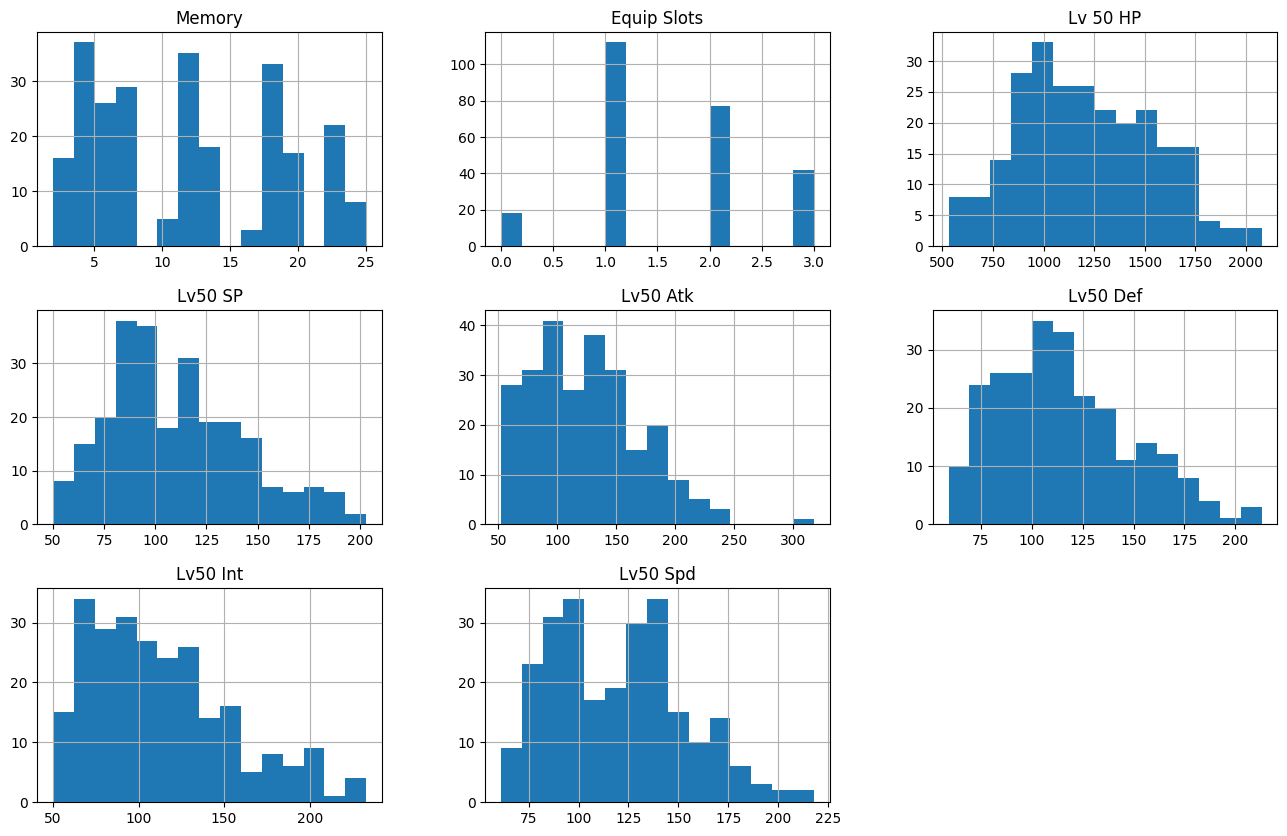

In [26]:
# Most Features (columns) are showing a difference between mean and median
# This indicates that the data is skewed
hist = db.hist(bins=15, figsize=(16, 10))

* `As we can see here we have `OUTLIERS in ATK`, also we have less than 10 Digimons with a high performance`

### HeatMaps with PANDAS and SNS

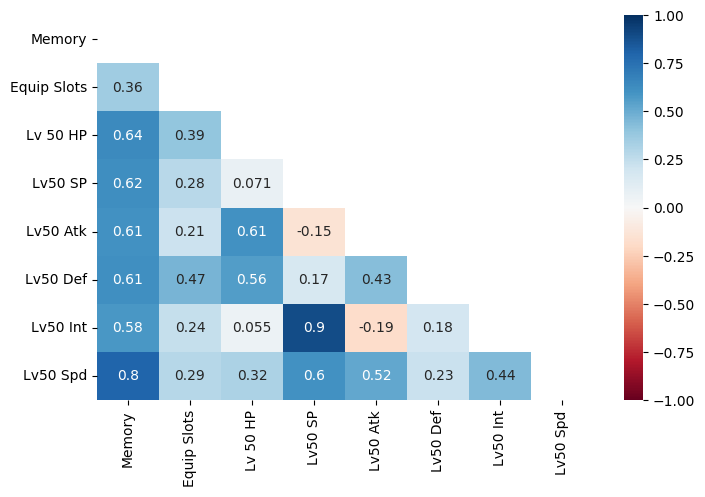

In [27]:
# Check correlation of the features (columns)
def df_corr(df):
    plt.figure(figsize=(8, 5))
    corr = df.corr(numeric_only=True)
    matrix = np.triu(corr)
    # Plot HeatMap with SNS
    sns.heatmap(
        corr,
        annot=True,
        mask=matrix,
        cmap="RdBu",
        vmin=-1,
        vmax=1,
    )


df_corr(db)

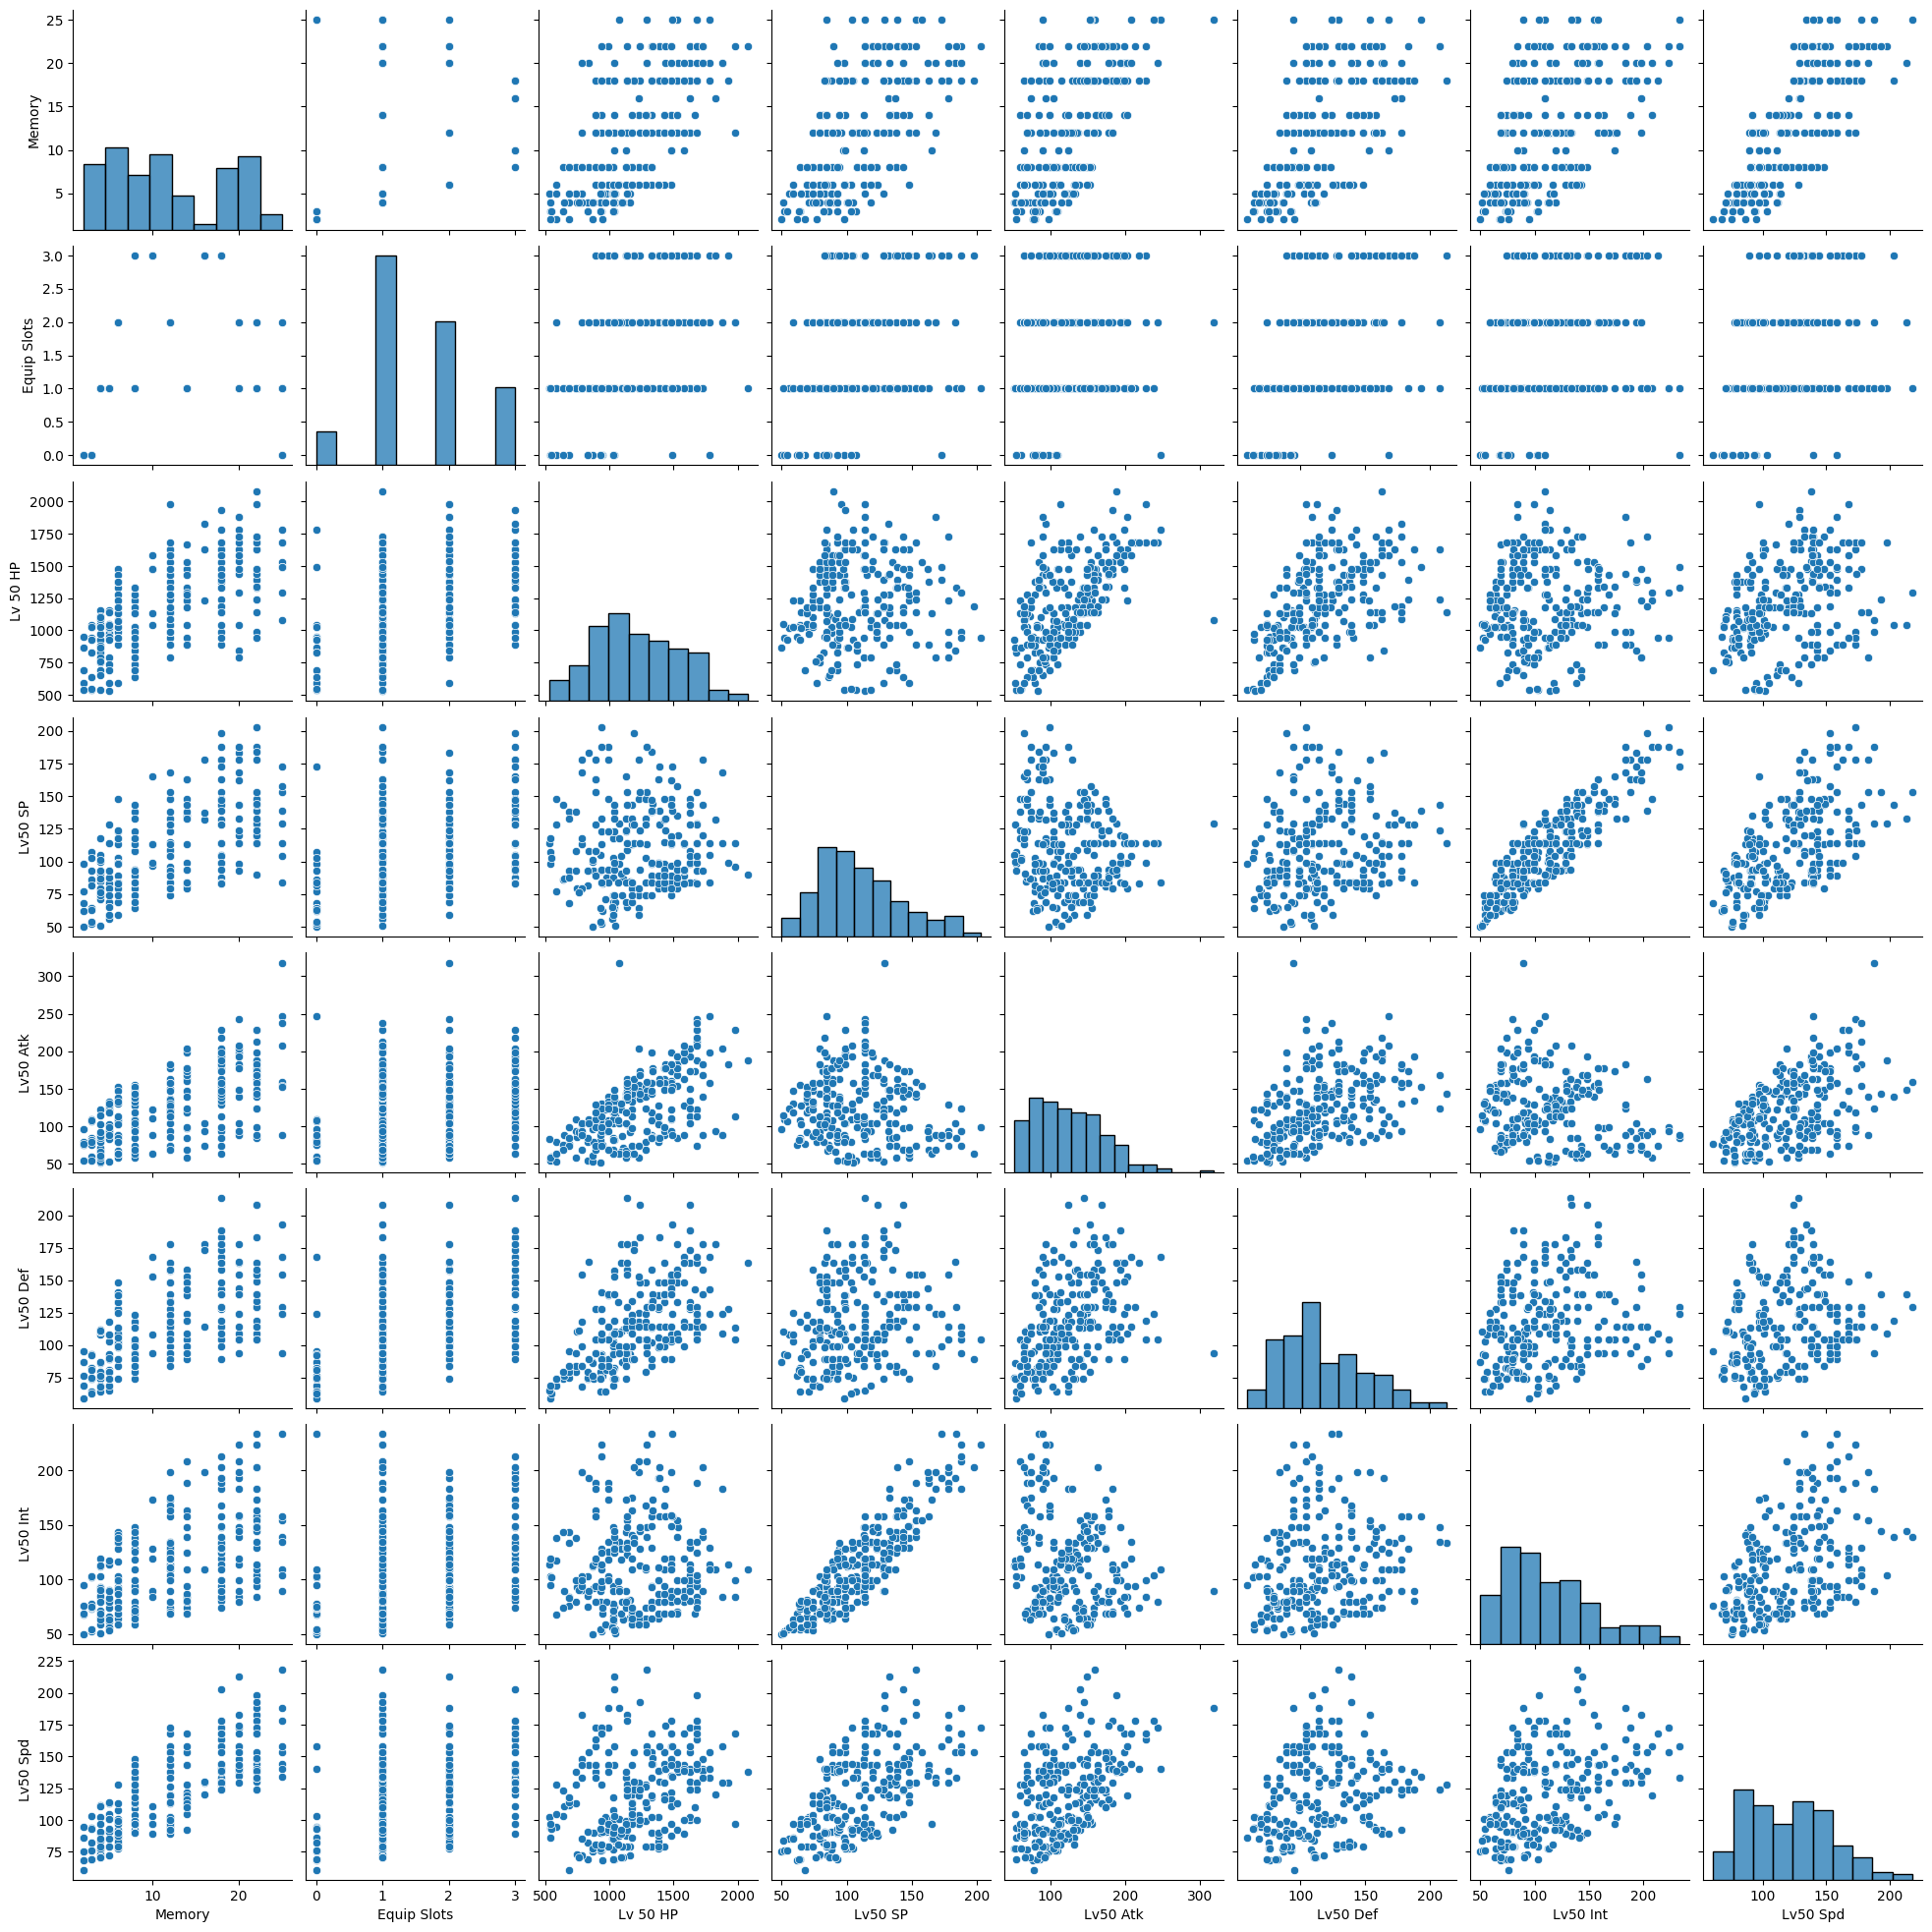

In [28]:
# Plot pairwise relationships
sns.pairplot(db)

In [29]:
# Show outliers
db["Lv50 Atk"].nlargest()

244    318
236    247
196    243
242    238
185    228
Name: Lv50 Atk, dtype: int16

In [30]:
def detect_outliers(df, num_var):
    trace0 = go.Box(
        y=df[num_var],
        name="All Points",
        jitter=0.3,
        pointpos=-1.8,
        boxpoints="all",
        marker=dict(color="#a2b9bc"),
        line=dict(color="#6b5b95"),
    )

    trace1 = go.Box(
        y=df[num_var],
        name="Only Whiskers",
        boxpoints=False,
        marker=dict(color="#b2ad7f"),
        line=dict(color="#feb236"),
    )

    trace2 = go.Box(
        y=df[num_var],
        name="Suspected Outliers",
        boxpoints="suspectedoutliers",
        marker=dict(
            color="#b5e7a0",
            outliercolor="#878f99",
            line=dict(outliercolor="#d64161", outlierwidth=2),
        ),
        line=dict(color="#86af49"),
    )

    trace3 = go.Box(
        y=df[num_var],
        name="Whiskers and Outliers",
        boxpoints="outliers",
        marker=dict(color="#6b5b95"),
        line=dict(color="#ff7b25"),
    )

    data = [trace0, trace1, trace2, trace3]

    layout = go.Layout(title="{} Outliers".format(num_var))

    layout = go.Layout(
        title={
            "text": num_var,
            "y": 0.9,
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
        barmode="overlay",
        yaxis=dict(title="Count"),
        template="plotly_dark",
    )

    fig = go.Figure(data=data, layout=layout)

    fig.show()


detect_outliers(db, "Lv50 Atk")

In [31]:
# Set upper limit for outliers
q_hi = db["Lv50 Atk"].quantile(0.999)
q_hi

300.39200000000267

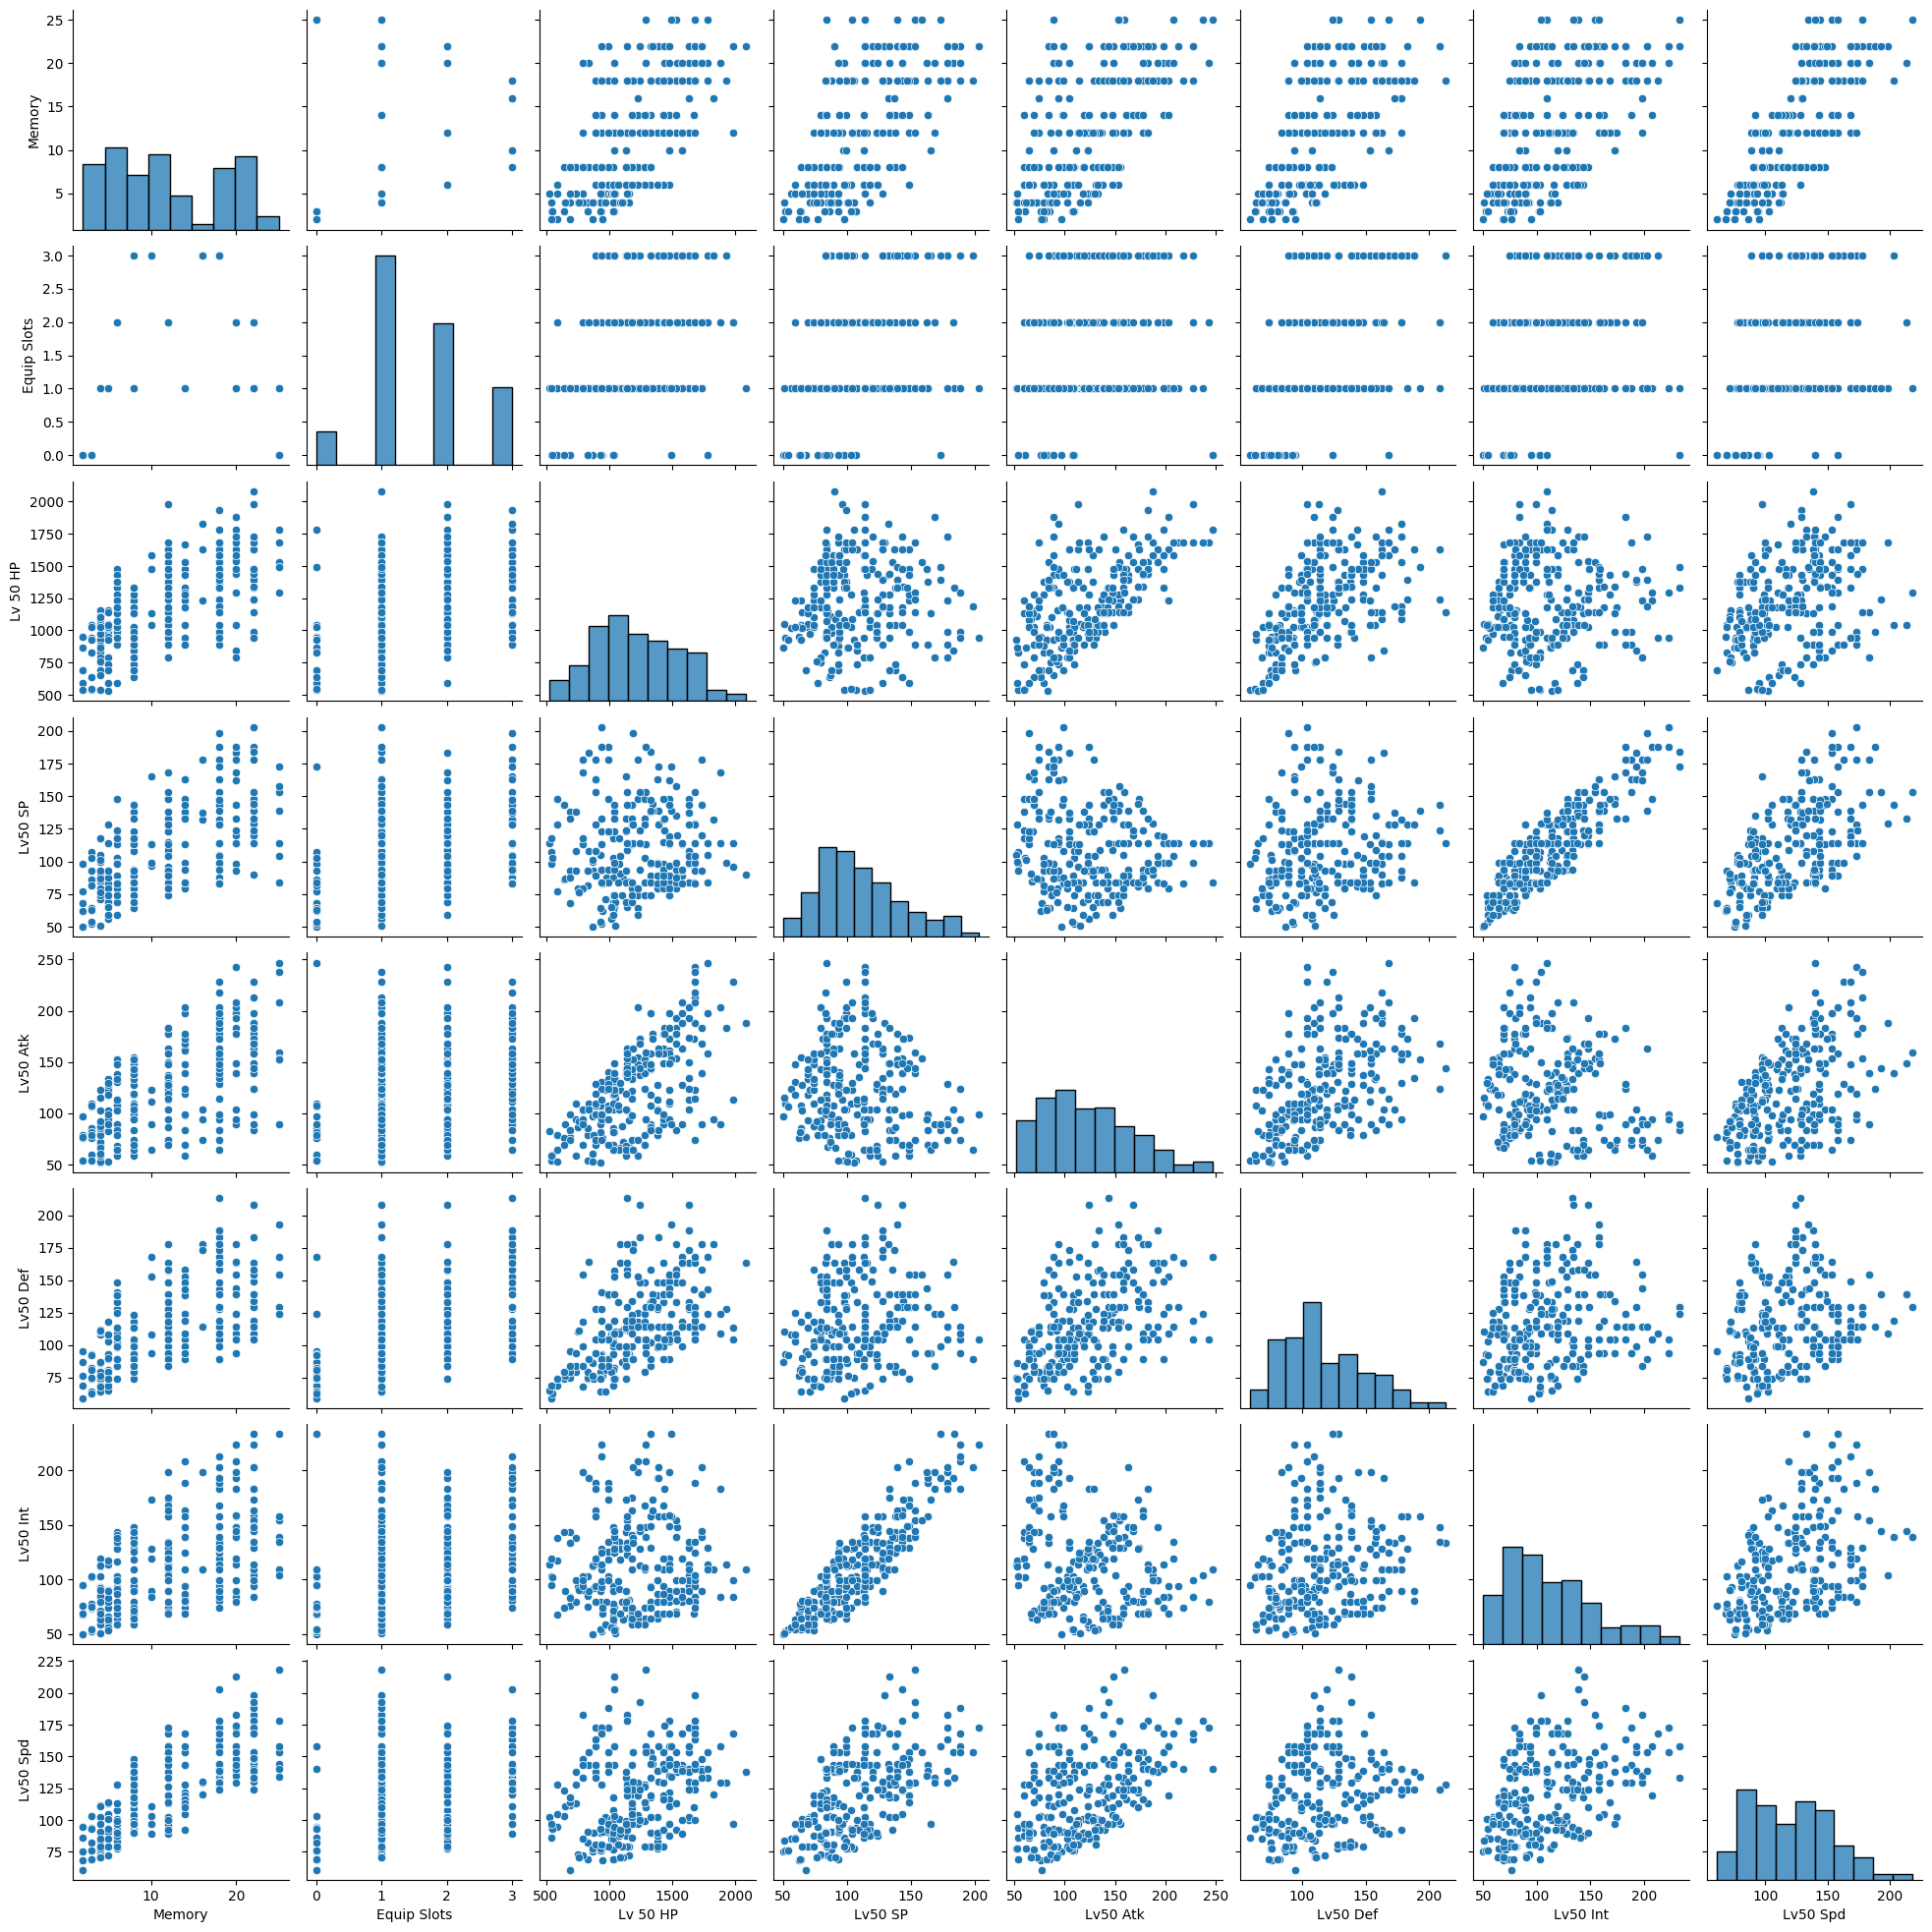

In [32]:
# Plot pairwise relationships w/o outliers
sns.pairplot(db.query("`Lv50 Atk` < @q_hi"))

## 3. Clean up the DataFrame

### 3.1 Using pandas to clean the data with method chaining

In [33]:
# Chain PANDAS method
(
    db.query("`Lv50 Atk` > 100")  # Using SQL method
    .filter(
        regex="^D", axis="columns"
    )  # Filter with regex all the COLUMNS NAME start with D
    .rename(columns={"Digimon": "Digimon_Name"})  # Rename the Column Name-
)

,Digimon_Name
6,Koromon
8,Tsunomon
9,Tsumemon
17,Agumon
18,Agumon (Blk)
...,...
245,Valkyrimon
246,ShineGreymon BM
247,MirageGaogamon BM
248,Ravemon BM


In [34]:
db.head(3)

,Digimon,Stage,Type,Attribute,Memory,Equip Slots,Lv 50 HP,Lv50 SP,Lv50 Atk,Lv50 Def,Lv50 Int,Lv50 Spd
1,Kuramon,Baby,Free,Neutral,2,0,590,77,79,69,68,95
2,Pabumon,Baby,Free,Neutral,2,0,950,62,76,76,69,68
3,Punimon,Baby,Free,Neutral,2,0,870,50,97,87,50,75


In [35]:
# Function to CLEAN
def clean_df(df, views_threshold=100):
    """
    Purpose: Clean the DataFrame
    """
    #  remove_cols=['Number']
    # remove_nan_values=['']
    return (
        df
        #   .drop(labels=remove_cols,axis='columns')
        #    .dropna(subset=remove_nan_values)
        .dropna()
        .pipe(
            clean_columns
        )  # Cleaning empty spaces and special characters. Imported at the beginning
        .rename(
            columns={
                "lv_50_hp": "hp",
                "lv_50_sp": "sp",
                "lv_50_atk": "atk",
                "lv_50_def": "def",
                "lv_50_int": "int",
                "lv_50_spd": "spd",
            }
        )
        .query("atk > @views_threshold")
        .assign(  # assign create a new column or edit the existing one
            #        atk=lambda df_: pd.to_datetime(df_.)
            atk_sp_ratio=lambda df_: ((df_.sp / df_.atk) * 100).round(2)
        )
    )


# end def

df = clean_df(db)
df.head(3)

12 column names have been cleaned

,digimon,stage,type,attribute,memory,equip_slots,hp,sp,atk,def,int,spd,atk_sp_ratio
6,Koromon,In-Training,Free,Fire,3,0,940,52,109,93,52,76,47.71
8,Tsunomon,In-Training,Free,Earth,3,0,930,54,107,92,54,76,50.47
9,Tsumemon,In-Training,Free,Dark,3,0,930,64,108,64,54,93,59.26


## 4. Plot data

In [36]:
def display_topn_cat_val(df, feature):
    df_ = df[feature].value_counts()
    fig = px.bar(
        y=df_.values,
        x=df_.index,
        text=df_.values,
        title="Amount of Digimon by Stage",
    )
    fig.update_layout(
        title={
            "text": feature.title(),
            "y": 0.9,
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
        barmode="overlay",
        yaxis=dict(title="Count"),
        xaxis=dict(title="Stage"),
        template="plotly_dark",
    )
    fig.show()


display_topn_cat_val(df, "stage")

In [37]:
# ax = (df
#  .stage
#  .value_counts()
#  .plot(kind='bar',figsize=(12,6),rot=0, title='Amount of Digimon by Stage', xlabel='Stage', ylabel='Amount')
#  )
# ax.bar_label(ax.containers[0])

# plt.tight_layout()

In [38]:
def summary_count(df, cols):
    colors = [
        "#a2b9bc",
        "#6b5b95",
        "#b2ad7f",
        "#feb236",
        "#b5e7a0",
        "#878f99",
        "#d64161",
        "#86af49",
        "#ff7b25",
    ]

    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=("Countplot", "Percentages"),
        specs=[[{"type": "xy"}, {"type": "domain"}]],
    )

    x = [str(i) for i in df[cols].value_counts().index]
    y = df[cols].value_counts().values.tolist()

    fig.add_trace(
        go.Bar(
            x=x,
            y=y,
            text=y,
            textposition="auto",
            showlegend=False,
            marker=dict(color=colors, line=dict(color="black", width=2)),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Pie(
            labels=df[cols].value_counts().keys(),
            values=df[cols].value_counts().values,
            hoverinfo="label",
            textinfo="percent",
            textfont_size=20,
            textposition="auto",
            marker=dict(colors=colors, line=dict(color="black", width=2)),
        ),
        row=1,
        col=2,
    )

    fig.update_layout(
        title={
            "text": cols.title(),
            "y": 0.9,
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
        template="plotly_dark",
    )

    fig.show()


for i in ["stage", "type"]:
    summary_count(df, i)

#### Which team of 3 digimon have the highest attack? Defense?


In [39]:
def plot_column(df, column, top_values=10, color="#d33682"):
    df_total = []
    title = f"<b>{column[0].replace('_',' ').title()} and {column[1].replace('_',' ').title()} - Top {top_values} Digimons</b>"
    mean = df[column].mean()
    median = df[column].median()
    fig = make_subplots(
        rows=2,
        cols=1,
        subplot_titles=(
            f"{column[0].replace('_',' ').title()}",
            f"{column[1].replace('_',' ').title()}",
        ),
        shared_xaxes=False,
        shared_yaxes=False,
        vertical_spacing=0.1,
    )
    for i, col in enumerate(column):
        df_col = df.nlargest(top_values, columns=col).sort_values(
            by=col, ascending=True
        )
        df_total.append(df_col)
        mean = df_total[i][column[i]].mean()
        median = df_total[i][column[i]].median()
        # Plot 1 - Bar chart
        fig.add_trace(
            go.Bar(
                x=df_total[i][col],
                y=df_total[i]["digimon"],
                orientation="h",
                marker_color=color,
                text=df_total[i]["type"],
                opacity=1,
                hovertemplate="<b> Digimon:%{y} </br><b> "
                f"{col.title()}"
                ":%{x} <br> Type:%{text}",
                name="",
            ),
            row=i + 1,
            col=1,
        )

        # add a vertical "MEAN" line
        fig.add_shape(
            type="line",
            x0=mean,
            y0=0,
            x1=mean,
            y1=top_values - 0.5,
            line=dict(color="purple", width=3, dash="dot"),
            row=i + 1,
            col=1,
            visible=True,
            templateitemname=mean,
            name="mean",
        )
        # Add a text annotation for the MEAN value
        fig.add_annotation(
            x=mean,
            y=top_values,
            text="Mean",
            hovertext=f"Mean: {mean:.2f}",
            align="center",
            row=i + 1,
            col=1,
            textangle=50,
            font=dict(size=10, color="gray"),
            xshift=-10,
        )

        # add a vertical "MEDIAN" line
        fig.add_shape(
            type="line",
            x0=median,
            y0=0,
            x1=median,
            y1=top_values - 0.5,
            line=dict(color="salmon", width=3, dash="dot"),
            row=i + 1,
            col=1,
        )
        # Add a text annotation for the MEDIAN value
        fig.add_annotation(
            x=median,
            xref="x",
            y=top_values,
            yref="y",
            text="Median",
            hovertext=f"Median: {median:.2f}",
            align="center",
            row=i + 1,
            col=1,
            textangle=50,
            font=dict(size=10, color="gray"),
            opacity=1,
        )

    fig.update_layout(
        title_text=title,
        uirevision=dict(editable=False),
        bargap=0,
        yaxis1=(
            dict(
                showgrid=False,
                title=None,
                showticklabels=True,
                visible=True,
                zeroline=False,
            )
        ),
        yaxis2=(
            dict(
                showgrid=False,
                title=None,
                showticklabels=True,
            )
        ),
        xaxis1=(
            dict(
                showgrid=False,
                title=None,
                showticklabels=True,
                visible=True,
                zeroline=False,
            )
        ),
        xaxis2=(
            dict(
                showgrid=False,
                title=None,
                showticklabels=True,
                visible=True,
                zeroline=False,
            )
        ),
        margin=dict(l=0, r=0, t=50, b=15),
        showlegend=False,
        hoverlabel=dict(
            bgcolor="#ff8fc5",
            font_family="Times New Roman",
        ),
        template="plotly_white",
        annotations=[
            dict(
                showarrow=False,
            )
        ],
    )
    return fig


fig = plot_column(df=df, column=["atk", "def"], top_values=3)
fig.show()

### Are some types over- or under-represented?


In [53]:

df_group = df.groupby(["stage", "type"])["digimon"].count().reset_index()
df_group

,stage,type,digimon
0,Armor,Free,2
1,Armor,Vaccine,1
2,Champion,Data,7
3,Champion,Free,4
4,Champion,Vaccine,10
5,Champion,Virus,14
6,In-Training,Free,3
7,Mega,Data,15
8,Mega,Free,5
9,Mega,Vaccine,16


In [54]:
fig = px.bar(
    df_group,
    x="stage",
    y="digimon",
    title="Stage Of Digimon and Amount of each",
    color="type",
    text="type",
    template="plotly_white",
)
fig.update_layout(
    barmode="group",
    plot_bgcolor="rgba(0,0,0,0)",
    yaxis=(dict(showgrid=False, title=None)),
    xaxis=(dict(showgrid=False, title=None, categoryorder="total descending")),
    legend=(dict(title={"text": "Type"})),
)

fig.update_traces(
    texttemplate="%{value}",
    textposition="outside",
    hovertemplate="<br>".join(
        ["Stage: %{x}", "Number of Digimons: %{y}", "Type: %{text}"]
    ),
)

fig.show()
# print("plotly express hovertemplate:", fig.layout)
# print("plotly express hovertemplate:", fig.data[0].hovertemplate)
#

What’s the tradeoff between HP and SP?


In [44]:
df[["hp", "sp"]]

,hp,sp
6,940,52
8,930,54
9,930,64
17,1030,59
18,1020,56
...,...,...
245,1330,139
246,1980,114
247,1440,124
248,1040,133


* Both the moves and support skills have short text descriptions. Can an NLP analysis reveal underlying clusters of moves?
* Are different types and attributes evenly represented across stages?

In [46]:
# OPTIONAL
fig.write_html("digimon-chart.html")

Both the moves and support skills have short text descriptions. Can an NLP analysis reveal underlying clusters of moves?
Are different types and attributes evenly represented across stages?

In [47]:
db_move.columns.tolist()

['Move', 'SP Cost', 'Type', 'Power', 'Attribute', 'Inheritable', 'Description']

In [48]:
db_move.columns.str.lower()

Index(['move', 'sp cost', 'type', 'power', 'attribute', 'inheritable',
       'description'],
      dtype='object')

In [49]:
# Function to CLEAN
def clean_df(df, views_threshold=100):
    """
    Purpose: Clean the DataFrame
    """
    #  remove_cols=['Number']
    # remove_nan_values=['']
    return (
        df
        #   .drop(labels=remove_cols,axis='columns')
        #    .dropna(subset=remove_nan_values)
        .dropna()
        .pipe(
            clean_columns
        )  # Cleaning empty spaces and special characters. Imported at the beginning
        .rename(columns=str.lower)
        .query("power > @views_threshold")
        .assign(  # assign create a new column or edit the existing one
            #        atk=lambda df_: pd.to_datetime(df_.)
            power_sp_ratio=lambda df_: ((df_.sp_cost / df_.power) * 100).round(
                2
            )
        )
    )


# end def

df_move = clean_df(db_move)
df_move.head(3)

7 column names have been cleaned

,move,sp_cost,type,power,attribute,inheritable,description,power_sp_ratio
2,Wolkenapalm III,9,Physical,105,Fire,Yes,"Physical attack, 105 Fire damage to one foe. 9...",8.57
12,Ice Archery III,9,Physical,105,Water,Yes,"Physical attack, 105 Water damage to one foe. ...",8.57
22,Crescent Leaf III,9,Physical,105,Plant,Yes,"Physical attack, 105 Plant damage to one foe. ...",8.57


### Which set of moves will get the best ratio of attack power to SP spent?


In [50]:
df_move.nlargest(3, columns="power_sp_ratio")

,move,sp_cost,type,power,attribute,inheritable,description,power_sp_ratio
364,Divine Atonement,30,Magic,105,Light,No,"Magic attack, 105 Light damage to all foes.",28.57
362,Transcendent Sword,30,Physical,115,Fire,No,"Physical attack, 115 Fire damage to all foes.",26.09
377,Odin's Breath,25,Physical,105,Water,No,"Physical attack, 105 Water damage to all foes....",23.81


In [70]:
df_move

,move,sp_cost,type,power,attribute,inheritable,description,power_sp_ratio,sp_power
2,Wolkenapalm III,9,Physical,105,Fire,Yes,"Physical attack, 105 Fire damage to one foe. 9...",11.67,NaN
12,Ice Archery III,9,Physical,105,Water,Yes,"Physical attack, 105 Water damage to one foe. ...",11.67,NaN
22,Crescent Leaf III,9,Physical,105,Plant,Yes,"Physical attack, 105 Plant damage to one foe. ...",11.67,NaN
32,Nanomachine Break III,9,Physical,105,Thunder,Yes,"Physical attack, 105 Thunder damage to one foe...",11.67,NaN
42,Comet Hammer III,9,Physical,105,Earth,Yes,"Physical attack, 105 Earth damage to one foe. ...",11.67,NaN
...,...,...,...,...,...,...,...,...,...
377,Odin's Breath,25,Physical,105,Water,No,"Physical attack, 105 Water damage to all foes....",4.20,NaN
378,Shield of the Just,25,Magic,115,Light,No,"Magic attack, 115 Light damage to one foe. Alw...",4.60,NaN
380,Black Aura Blast,25,Magic,110,Dark,No,"Magic attack, 110 Dark damage to one foe. Decr...",4.40,NaN
382,Garuru Tomahawk,20,Physical,140,Neutral,No,"Physical attack, 140 Neutral damage to one foe...",7.00,NaN


In [69]:
df_move['power_sp_ratio']=df_move['power']/df_move['sp_cost']

In [51]:
db_move[["Move", "SP Cost", "Power"]]

,Move,SP Cost,Power
0,Wolkenapalm I,3,65
1,Wolkenapalm II,6,85
2,Wolkenapalm III,9,105
3,Burst Flame I,3,55
4,Burst Flame II,6,75
...,...,...,...
382,Garuru Tomahawk,20,140
383,Fist of Athena,50,0
384,Supreme Cannon,30,130
385,Dark Prominence,30,0


In [61]:
db_move_sp_power = db_move.groupby(["Move", "SP Cost", "Power"]).size()


fig = go.Figure()
categories = ['Weak', 'Medium', 'Strong']
fig.add_trace(go.Scatterpolar(
            r = db_move_sp_power.unique(), theta = categories, 
            fill = 'toself', name = '2020 remote ratio'))

fig.add_trace(go.Scatterpolar(
            r = ratio_2021, theta = categories,
            fill = 'toself', name = '2021 remote ratio'))

fig.add_trace(go.Scatterpolar(
            r = ratio_2022, theta = categories,
            fill = 'toself', name = '2022 remote ratio'))

fig.add_trace(go.Scatterpolar(
            r = ratio_2023, theta = categories,
            fill = 'toself', name = '2023 remote ratio'))
fig.update_layout(title={'text': "Remote Ratio ",
                             'y':0.9,
                             'x':0.5,
                             'xanchor':'center',
                             'yanchor':'top'},
                             barmode='overlay',
                             yaxis=dict(title='Count'),
                             template = 'plotly_dark')
fig.show()